In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from fig_style import *

import sys
sys.path.insert(0,'../')
from disk_model import DiskFitting

import astropy.constants as const
au = const.au.cgs.value
Msun = const.M_sun.cgs.value
Mearth = const.M_earth.cgs.value

In [2]:
with open('../data/fitted_systems/fit_1mm_Q1d5_age1e5.pkl','rb') as f:
    Ds = np.array(pickle.load(f))

import astropy.table
data = astropy.table.Table.read("../data/VANDAM_T20_properties.txt", format="ascii")
data.add_index('Source') # add index by source

In [3]:
def get_stats(Ds, output_for_table=False, head=''):
    Md = np.array([(D.disk_model.M-D.disk_model.Mstar)/Msun for D in Ds])
    Rd = np.array([D.disk_model.Rd/au for D in Ds])
    T_mid_center = np.array([D.disk_model.T_mid[np.argmin(np.abs(D.disk_model.R/D.disk_model.Rd-0.5))] for D in Ds])
    if output_for_table:
        s = head + '  '
        s += '& {:.2f} & {:.2f} & {:.2f} & {:.2f} '.format(np.mean(Md), np.percentile(Md, 25), np.median(Md) ,np.percentile(Md, 75))
        s += '& {:.1f} & {:.1f} & {:.1f} '.format(np.percentile(Rd, 25), np.median(Rd) ,np.percentile(Rd, 75))
        s += '& {:.1f} & {:.1f} & {:.1f} '.format(np.percentile(T_mid_center, 25), np.median(T_mid_center) ,np.percentile(T_mid_center, 75))
        s += r'\\'
        print(s)
    else:
        print('Md (mean, 25%, median, 75%): {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(np.mean(Md), np.percentile(Md, 25), np.median(Md) ,np.percentile(Md, 75)))
        print('Rd (25%, median, 75%): {:.2f}, {:.2f}, {:.2f}'.format(np.percentile(Rd, 25), np.median(Rd) ,np.percentile(Rd, 75)))
        print('T_mid(R/2) (25%, median, 75%): {:.2f}, {:.2f}, {:.2f}'.format(np.percentile(T_mid_center, 25), np.median(T_mid_center) ,np.percentile(T_mid_center, 75)))
    return Md, Rd, T_mid_center

def get_stats_T20(Ds, output_for_table=False, head=''):
    Md = np.array([
        data['MdiskA'][data.loc_indices[D.source_name]]*Mearth*100/Msun
        for D in Ds
    ])
    Rd = np.array([
        data['RdiskA'][data.loc_indices[D.source_name]]
        for D in Ds
    ])
    T_mid_center = np.array([
        43*data['Lbol'][data.loc_indices[D.source_name]]**0.25
        for D in Ds
    ])
    T_mid_center = T_mid_center[~np.isnan(T_mid_center)]
    if output_for_table:
        s = head + '  '
        s += '& {:.3f} & {:.3f} & {:.3f} & {:.3f} '.format(np.mean(Md), np.percentile(Md, 25), np.median(Md) ,np.percentile(Md, 75))
        s += '& {:.1f} & {:.1f} & {:.1f} '.format(np.percentile(Rd, 25), np.median(Rd) ,np.percentile(Rd, 75))
        s += '& {:.1f} & {:.1f} & {:.1f} '.format(np.percentile(T_mid_center, 25), np.median(T_mid_center) ,np.percentile(T_mid_center, 75))
        s += r'\\'
        print(s)
    else:
        print('Md (mean, 25%, median, 75%): {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(np.mean(Md), np.percentile(Md, 25), np.median(Md) ,np.percentile(Md, 75)))
        print('Rd (25%, median, 75%): {:.2f}, {:.2f}, {:.2f}'.format(np.percentile(Rd, 25), np.median(Rd) ,np.percentile(Rd, 75)))
        print('T_mid(R/2) (25%, median, 75%): {:.2f}, {:.2f}, {:.2f}'.format(np.percentile(T_mid_center, 25), np.median(T_mid_center) ,np.percentile(T_mid_center, 75)))
    return Md, Rd, T_mid_center

In [4]:
def get_class(D):
    i = data.loc_indices[D.source_name]
    if data['Class'][i]=='0':
        return 0
    if data['Class'][i]=='I':
        return 1
    if data['Class'][i]=='Flat':
        return 1.5
    if data['Class'][i]=='None':
        return -1
    else:
        raise ValueError('unknown class!')

In [5]:
cl = np.array([get_class(D) for D in Ds])

In [6]:
print('total:',len(cl))
print('Class 0:',np.sum(cl==0))
print('Class I:',np.sum(cl==1))
print('Flat:',np.sum(cl==1.5))
print('unclassified:',np.sum(cl==-1))

total: 156
Class 0: 96
Class I: 36
Flat: 20
unclassified: 4


# Disk property summary (Table 2)

In [7]:
# select the subsample with chi^2 <= 2
from get_chi_sq import get_mean_chisq_mult
chi_sq = get_mean_chisq_mult(Ds)
Ds_low_chi = Ds[chi_sq<=2]
print(len(Ds_low_chi))

cl_low_chi = np.array([get_class(D) for D in Ds_low_chi])

115


In [8]:
data_all=get_stats(Ds_low_chi, output_for_table=True, head='All')
data_0=get_stats(Ds_low_chi[cl_low_chi==0], output_for_table=True, head='Class 0')
data_I=get_stats(Ds_low_chi[cl_low_chi==1], output_for_table=True, head='Class I')
data_Flat=get_stats(Ds_low_chi[cl_low_chi==1.5], output_for_table=True, head='Flat Spectrum')
_=get_stats_T20(Ds_low_chi, output_for_table=True, head='T20')

All  & 0.94 & 0.31 & 0.65 & 1.21 & 28.7 & 68.0 & 141.9 & 16.8 & 50.7 & 129.8 \\
Class 0  & 0.95 & 0.31 & 0.75 & 1.24 & 31.8 & 87.2 & 157.8 & 11.7 & 47.1 & 129.6 \\
Class I  & 1.14 & 0.46 & 0.71 & 1.32 & 29.8 & 52.8 & 116.8 & 30.6 & 81.1 & 147.6 \\
Flat Spectrum  & 0.48 & 0.19 & 0.28 & 0.49 & 29.0 & 50.2 & 84.7 & 15.7 & 26.6 & 58.7 \\
T20  & 0.023 & 0.005 & 0.014 & 0.030 & 32.6 & 48.4 & 80.8 & 45.0 & 58.6 & 78.6 \\


<ipython-input-3-8065bb7e3576>:27: UserWarning: Warning: converting a masked element to nan.
  T_mid_center = np.array([


# Class dependence plot (Fig. 13)

In [9]:
def plot_cumulative_dist(x, **kwargs):
    N = len(x)
    x = np.concatenate(([0],np.sort(x)))
    y = 1-np.arange(N+1)/(N)
    p,=plt.plot(x,y,**kwargs)
    return p

In [10]:
import matplotlib
N = 3
colors = matplotlib.cm.get_cmap('plasma')((np.arange(N)+0.5)/N)[::-1]

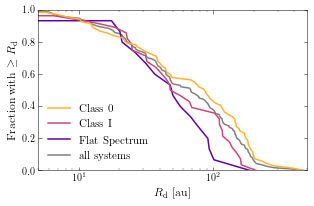

In [11]:
plt.figure(figsize=(4.5,3))
p4=plot_cumulative_dist(data_all[1], color='tab:grey')
p3=plot_cumulative_dist(data_Flat[1], color=colors[2])
p2=plot_cumulative_dist(data_I[1], color=colors[1])
p1=plot_cumulative_dist(data_0[1], color=colors[0])
plt.legend([p1,p2,p3,p4],['Class 0','Class I','Flat Spectrum','all systems'], frameon=False)
plt.xlim(5,500); plt.xscale('log'); plt.xlabel(r'$R_{\rm d}$ [au]')
plt.ylim(0,1); plt.ylabel(r'Fraction with $\geq R_{\rm d}$')
set_ticks()
plt.tight_layout()
plt.savefig('../figures/class_Rd.pdf',bbox_inches='tight')

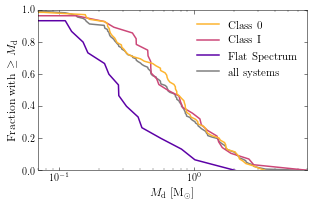

In [12]:
plt.figure(figsize=(4.5,3))
p4=plot_cumulative_dist(data_all[0], color='tab:grey')
p3=plot_cumulative_dist(data_Flat[0], color=colors[2])
p2=plot_cumulative_dist(data_I[0], color=colors[1])
p1=plot_cumulative_dist(data_0[0], color=colors[0])
plt.legend([p1,p2,p3,p4],['Class 0','Class I','Flat Spectrum','all systems'], frameon=False)
plt.xlim(7e-2,7); plt.xscale('log'); plt.xlabel(r'$M_{\rm d}$ [M$_\odot$]');
plt.ylim(0,1); plt.ylabel(r'Fraction with $\geq M_{\rm d}$')
set_ticks()
plt.tight_layout()
plt.savefig('../figures/class_Md.pdf',bbox_inches='tight')

# Sensitvity to model parameter (Table B1)

In [13]:
def get_data_one(D):
    DM = D.disk_model
    Md_over_Mstar = (DM.M-DM.Mstar)/DM.Mstar
    T_mid_center = DM.T_mid[np.argmin(np.abs(DM.R/DM.Rd-0.5))]
    Sigma_center = DM.Sigma[np.argmin(np.abs(DM.R/DM.Rd-0.5))]
    return [DM.Rd/au, (DM.M-DM.Mstar)/Msun, DM.Mstar/Msun, Md_over_Mstar, T_mid_center, Sigma_center]
def get_data(Ds):
    d = [get_data_one(D) for D in Ds[chi_sq<=2]]
    return np.array(d)
def get_parameter_sensitivity(D1, D2, dlogx):
    d1 = get_data(D1)
    d2 = get_data(D2)
    dlogy_mean = np.mean(np.log(d2)-np.log(d1), axis=0)/dlogx
    dlogy_std = np.std(np.log(d2)-np.log(d1), axis=0)/dlogx
    dlogy_rms = np.sqrt(np.mean((np.log(d2)-np.log(d1))**2, axis=0))/dlogx
    y_names = ['Rd','Md','Mstar','Md/Mstar','Tmid half','Sigma half']
    s = ''
    for i in range(len(dlogy_mean)):
        #print(y_names[i]+' {:+.2f}$\pm${:.2f}'.format(dlogy_mean[i],dlogy_std[i]))
        s += '& {:+.2f}$\pm${:.2f} '.format(dlogy_mean[i],dlogy_std[i])
    s += r'\\'
    print(s)
    return dlogy_rms

In [14]:
with open('../data/fitted_systems/fit_1mm_Q1d5_age1e5.pkl','rb') as f:
    Ds = np.array(pickle.load(f))
with open('../data/fitted_systems/fit_1mm_Q1_age1e5.pkl','rb') as f:
    Ds_Q1 = np.array(pickle.load(f))
with open('../data/fitted_systems/fit_1mm_Q2_age1e5.pkl','rb') as f:
    Ds_Q2 = np.array(pickle.load(f))
with open('../data/fitted_systems/fit_1cm_Q1d5_age1e5.pkl','rb') as f:
    Ds_1cm = np.array(pickle.load(f))
with open('../data/fitted_systems/fit_100um_Q1d5_age1e5.pkl','rb') as f:
    Ds_100um = np.array(pickle.load(f))
with open('../data/fitted_systems/fit_1mm_Q1d5_age5e4.pkl','rb') as f:
    Ds_Mdot_double = np.array(pickle.load(f))
with open('../data/fitted_systems/fit_1mm_Q1d5_age2e5.pkl','rb') as f:
    Ds_Mdot_half = np.array(pickle.load(f))

In [15]:
dlogy_rms_a = get_parameter_sensitivity(Ds_100um, Ds_1cm, np.log(100))
dlogy_rms_Mdot = get_parameter_sensitivity(Ds_Mdot_half, Ds_Mdot_double, np.log(4))
dlogy_rms_Q = get_parameter_sensitivity(Ds_Q1, Ds_Q2, np.log(2))

& +0.09$\pm$0.11 & -0.05$\pm$0.05 & -0.05$\pm$0.13 & -0.01$\pm$0.08 & -0.24$\pm$0.23 & -0.28$\pm$0.30 \\
& -0.02$\pm$0.24 & -0.17$\pm$0.14 & -0.47$\pm$0.39 & +0.30$\pm$0.26 & +0.07$\pm$0.51 & -0.06$\pm$0.70 \\
& -0.31$\pm$0.61 & -0.82$\pm$0.51 & +1.60$\pm$1.31 & -2.41$\pm$0.87 & +0.79$\pm$1.42 & -0.16$\pm$1.86 \\


In [16]:
dlogx_est_a = np.log(10)
dlogx_est_Mdot = np.log(10)
dlogx_est_Q = np.log(2)/2
dlogy = np.sqrt( dlogy_rms_a**2   * dlogx_est_a**2
                +dlogy_rms_Mdot**2* dlogx_est_Mdot**2
                +dlogy_rms_Q**2   * dlogx_est_Q**2)

In [17]:
def print_rms(dlogy_rms, dlogx_est):
    dlogy = dlogy_rms*dlogx_est
    s = ''
    for i in range(len(dlogy)):
        s += '& {:.2f} '.format(dlogy[i])
    s += r'\\'
    print(s)

In [18]:
print_rms(dlogy_rms_a, dlogx_est_a)
print_rms(dlogy_rms_Mdot, dlogx_est_Mdot)
print_rms(dlogy_rms_Q, dlogx_est_Q)
print_rms(dlogy, 1)

& 0.34 & 0.17 & 0.31 & 0.19 & 0.77 & 0.95 \\
& 0.55 & 0.50 & 1.40 & 0.91 & 1.19 & 1.62 \\
& 0.24 & 0.33 & 0.72 & 0.89 & 0.56 & 0.65 \\
& 0.69 & 0.63 & 1.60 & 1.29 & 1.52 & 1.99 \\


# Estimate covariance (for scatter plots)

In [19]:
def get_cov(D1, D2, dlogx_D, dlogx_est):
    d1 = get_data(D1)
    d2 = get_data(D2)
    dlogy = np.log(d2)-np.log(d1)
    N = dlogy.shape[0]
    covy = np.transpose(dlogy).dot(dlogy)/N/dlogx_D**2*dlogx_est**2
    return covy

In [20]:
covy_a = get_cov(Ds_100um, Ds_1cm, np.log(100), np.log(10))
covy_Mdot = get_cov(Ds_Mdot_half, Ds_Mdot_double, np.log(4), np.log(10))
covy_Q = get_cov(Ds_Q1, Ds_Q2, np.log(2), np.log(2)/2)
covy = covy_a+covy_Mdot+covy_Q

In [21]:
np.sqrt(covy[0,0])

0.6913233134287137

In [22]:
# Mstar vs Mdisk
print(covy[2,2], covy[1,1], covy[2,1])

2.5714915060417005 0.391028923446095 0.6517567189474585


In [23]:
# Rdisk vs Mdisk
print(covy[0,0], covy[1,1], covy[0,1])

0.47792792369005543 0.391028923446095 -0.13481476262969155


# How many systems' radius estimate is only a lower limit?

In [9]:
def get_F_edge_over_sigma_obs(D):
    F_edge = D.disk_model.F_obs[0][-1]
    sigma_obs = D.disk_image_list[0].rms_Jy
    F_edge_Jy_beam = F_edge*1e23*D.disk_image_list[0].beam_area
    return F_edge_Jy_beam/sigma_obs
F_over_sigma = np.array([get_F_edge_over_sigma_obs(D) for D in Ds])

In [19]:
np.sum(F_over_sigma<1.01)

31